In [3]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.figures.figureM4 import predict_mutants
from msresist.clustering import PSPSLdict
import numpy as np
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## Tweak Upstream Kinases Plot

In [4]:
with open('msresist/data/pickled_models/AXLmodel_PAM250_W2_5CL', 'rb') as p:
    model = pickle.load(p)[0]

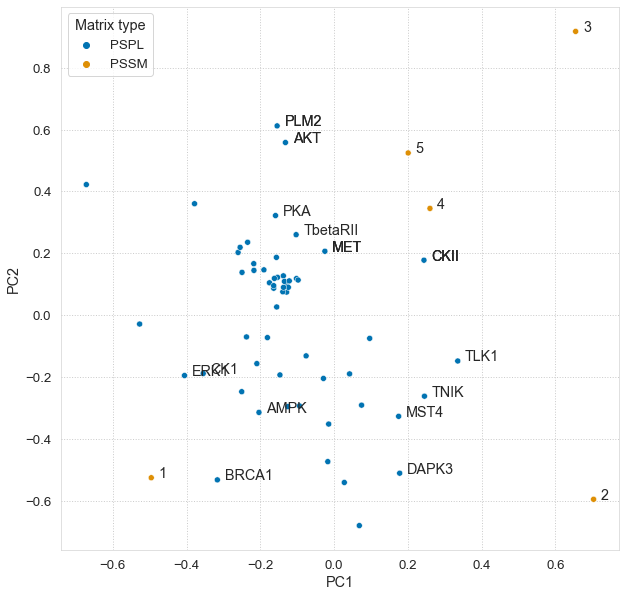

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plotUpstreamKinases(model, ax=ax, clusters=[1,2,3,4,5], n_components=2)

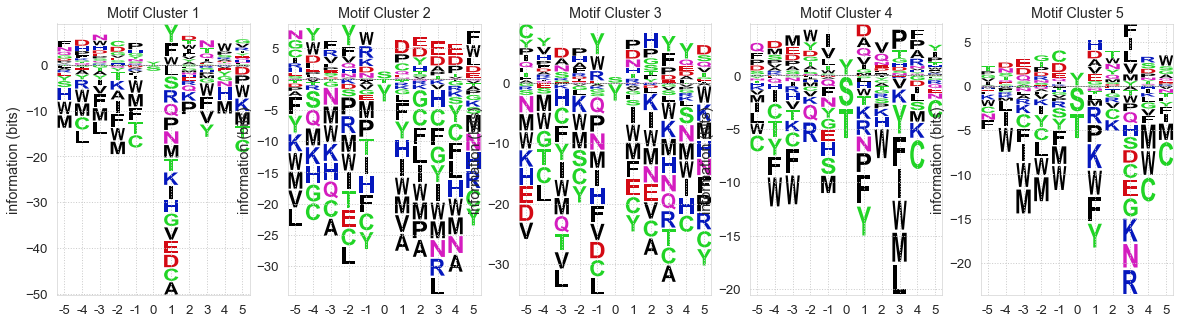

In [52]:
from msresist.figures.figure3 import plotMotifs

pssms = model.pssms(PsP_background=True)

fig, ax = plt.subplots(1, 5, figsize=)
plotMotifs(pssms, [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], axes=ax)

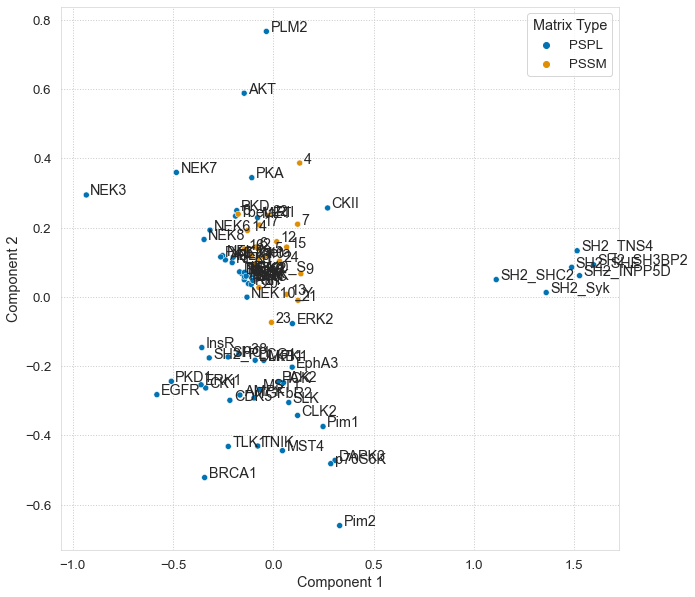

In [5]:
from msresist.figures.figure3 import plotUpstreamKinases

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plotUpstreamKinases(model, ax=ax, n_components=2)

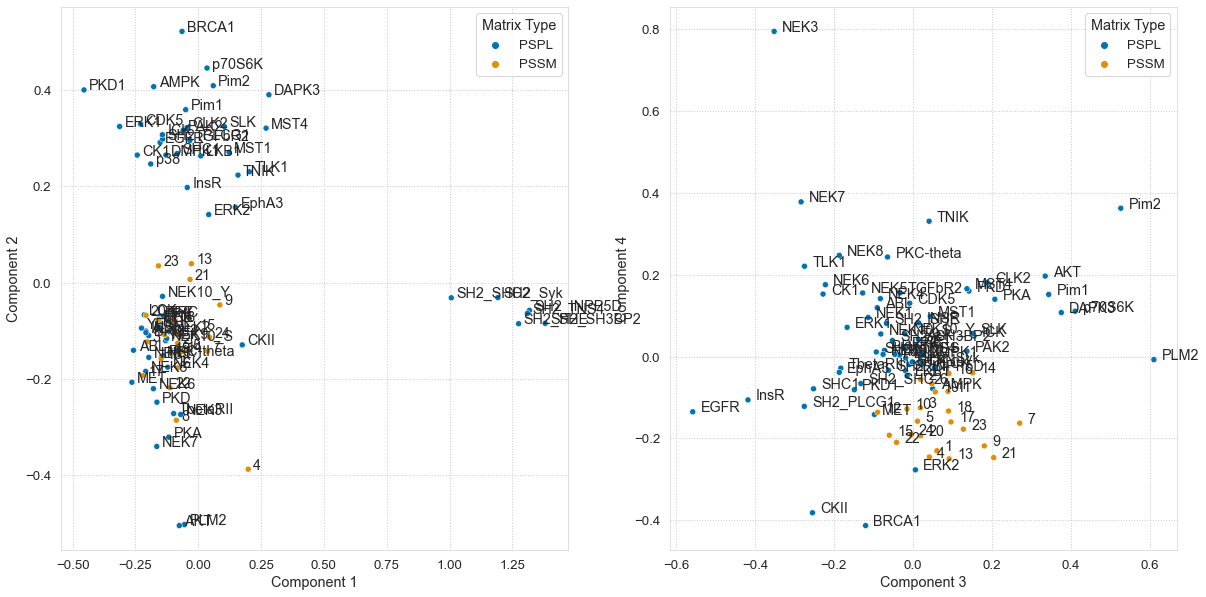

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plotUpstreamKinases(model, ax=ax, n_components=4)

## Regression against methylation

In [8]:
with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [158]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv").sort_values(by="Sample.ID").set_index("Sample.ID")
mtl = mutations["CIMP.status"]
mtl = mtl[~mtl.index.str.contains("IR")]

In [159]:
centers = pd.DataFrame(model.transform())
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers["Patient_ID"] = X.columns[4:]
centers = centers.set_index("Patient_ID").sort_values(by="Patient_ID")
assert all(mtl.index == centers.index), "sampels not matching"

In [160]:
centers["drop"] = pd.isnull(mtl).values
centers = centers[centers["drop"] == False]

mtl = mtl.dropna().
assert all(centers.index == mtl.index), "samples not matching."